### Movie Recommender System
This is an app that is built to recommend movie based on collaroborative filering using Singular Value Decomposition (SVD) method.

### About the dataset 
The dataset describe movies' ratings from MovieLens for which a total of 3,426 movies rated by 6,040 users.

Source: https://grouplens.org/datasets/movielens/1m/

In [ ]:
#import and install related libraries
#!pip -q install surprise
import numpy as np
np.seterr(divide='ignore',invalid='ignore')
import pandas as pd
import re
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise import Reader, Dataset, KNNBasic
from surprise import SVD
import matplotlib.pyplot as plt
import seaborn as sns

#load the data
data = pd.io.parsers.read_csv('Downloads/BDA_app/ratings.dat',names = ['user_id','movie_id','rating','time'], engine = 'python', delimiter = '::')
movie_data = pd.io.parsers.read_csv('Downloads/BDA_app/movies.dat',names = ['movie_id','title','genre'],engine = 'python',delimiter = '::')

#combine the two dataset by using the unique movie id
df_movies = movie_data.merge(data, on='movie_id')



## The Top 10 Rated Movie based on user input

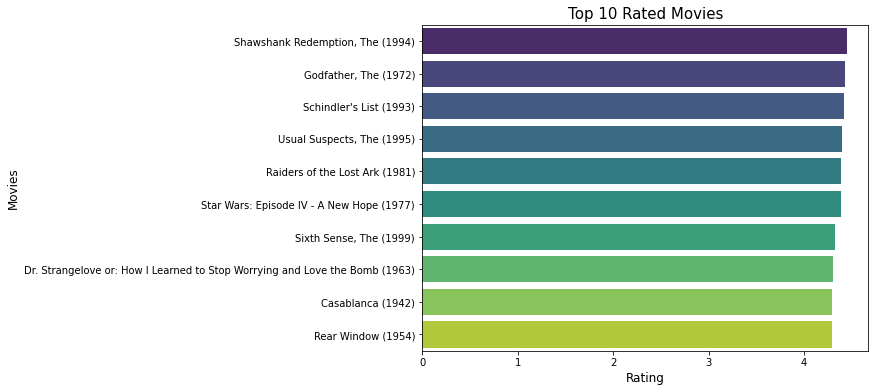

In [ ]:
#check the movies with by using weighted rating to avoid biased rating

#get the count of each movie
df_rating = df_movies[['title']]
df_rating = df_rating.apply(pd.value_counts)
df_rating = df_rating.reset_index().rename(columns={'index': 'title','title': 'freq'})
df_rating = pd.DataFrame.drop_duplicates(df_rating)

#get the average rating of each movie
df_rating_sum = df_movies[['title','rating']]
df_rating_sum = df_rating_sum.groupby(['title']).sum()

#merge the two dataframe
df_average_rating = df_rating_sum.merge(df_rating, on='title')
df_average_rating['average rating'] = df_average_rating['rating']/df_average_rating['freq']
m = df_average_rating['freq'].quantile(0.6)
C = df_average_rating['average rating'].mean()

def weighted_vote_average(record):
  v = record['freq']
  R = record['average rating']

  return ((v / (v+m)) * R) + ((m / (m+v)) * C)

df_average_rating['weighted_rate'] = df_average_rating.apply(weighted_vote_average, axis=1)

#check the top 10 rated movies
movie_popularity=df_average_rating[['title','weighted_rate']]
plot=movie_popularity.sort_values('weighted_rate',ascending=False).head(10)

#visualize the top 10 most popular movies
plt.figure(figsize=(8,6))
sns.barplot(y='title',x='weighted_rate', data=plot, palette='viridis')
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Movies", fontsize=12)
plt.title("Top 10 Rated Movies", fontsize=15)
plt.show()

In [ ]:
#Movie Recommendation

ratings_mat = np.ndarray (shape=(np.max(data.movie_id.values),np.max(data.user_id.values)),dtype=np.uint8)
ratings_mat[data.movie_id.values-1,data.user_id.values-1] = data.rating.values

normalised_mat = ratings_mat - np.asarray([(np.mean(ratings_mat, 1))]).T

A = normalised_mat.T / np.sqrt(ratings_mat.shape[0] - 1)
U, S, V = np.linalg.svd(A)

import ipywidgets as widgets
movieid = widgets.IntSlider(min=0, max=3293, step=1, description='Movie ID:', value=50)
display(movieid)

output_movieid = widgets.Output()

def movieid_eventhandler(change):
   output_movieid.clear_output()
   with output_movieid:
    if(int(change.new) == 50):
     print("The selected movie is: {0} \n".format(movie_data[movie_data.movie_id == slider.value].title.values[0]))
     updateFilmResult()
    else:
     print("The selected movie is: {0} \n".format(movie_data[movie_data.movie_id == int(change.new)].title.values[0]))
     updateFilmResult()
movieid.observe(movieid_eventhandler, names='value')

display(output_movieid)

def print_similar_movies(movie_data, movie_id, top_indexes):
  print('Other films you might enjoy based on your previous selection: \n')
  df = pd.DataFrame(columns =['index','movie_id','title','genre'])
  for id in top_indexes + 1:
   df = df.append(pd.DataFrame(movie_data[movie_data.movie_id == id]), ignore_index = True)
   df['year'] = df['title'].str.extract(r"\((\d+)\)", expand=False)
   df = df[['title','genre','year']]
   pd.set_option('display.max_colwidth', 40) 
  display(df)

def top_cosine_similarity(data, movie_id, top_n=10):
     index = movie_id - 1 # Movie id starts from 1 in the dataset
     movie_row = data[index, :]
     magnitude = np.sqrt(np.einsum('ij, ij -> i', data, data))
     similarity = np.dot(movie_row, data.T) / (magnitude[index] * magnitude)
     sort_indexes = np.argsort(-similarity)
     return sort_indexes[:top_n]

top_n =widgets.Dropdown(options = ['1','2','3','4','5','6','7','8','9','10'], value = '5', step=1, description = 'Top N Result')
display(top_n)
output_top_n = widgets.Output()

def top_n_eventhandler(change):
  output_top_n.clear_output()
  k = 50
  sliced = V.T[:, :k] # representative data
  with output_top_n:
   if(int(change.new) == 5):
    indexes = top_cosine_similarity(sliced, movieid.value, 5)
    display(print_similar_movies(movie_data, movieid.value, indexes))
   else:
    indexes = top_cosine_similarity(sliced, movieid.value, int(change.new))
    display(print_similar_movies(movie_data, movieid.value, indexes))

#create another function to update film result on movieid change 
def updateFilmResult():
  output_top_n.clear_output()
  k = 50
  sliced = V.T[:, :k] # representative data
  with output_top_n:
   if(int(top_n.value) == 5):
    indexes = top_cosine_similarity(sliced, movieid.value, 5)
    display(print_similar_movies(movie_data, movieid.value, indexes))
   else:
    indexes = top_cosine_similarity(sliced, movieid.value, int(top_n.value))
    display(print_similar_movies(movie_data, movieid.value, indexes)) 

top_n.observe(top_n_eventhandler, names='value')
display(output_top_n)




IntSlider(value=50, description='Movie ID:', max=3293)

Output()

Dropdown(description='Top N Result', index=4, options=('1', '2', '3', '4', '5', '6', '7', '8', '9', '10'), val…

Output()